In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pickle
import nltk

nltk.download('punkt')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

class FakeNewsDetection():
    def __init__(self, input_file, test_data_ratio):
        self.df = pd.read_csv(input_file, encoding='utf-8', header=0)
        self.test_data_ratio = test_data_ratio
        print(self.df.head())
        print(self.test_data_ratio)

    def preprocess_data(self, data):
        tk = RegexpTokenizer('\s+', gaps=True)
        text_data = []

        for values in data.text:
            tokenized_data = tk.tokenize(values)
            text_data.append(tokenized_data)

        sw = stopwords.words('english')
        clean_data = []

        for data in text_data:
            clean_text = [words.lower() for words in data if words.lower() not in sw]
            clean_data.append(clean_text)

        ps = PorterStemmer()
        stemmed_data = []

        for data in clean_data:
            stemmed_text = [ps.stem(words) for words in data]
            stemmed_data.append(stemmed_text)

        updated_data = []

        for data in stemmed_data:
            updated_data.append(" ".join(data))

        return updated_data

    def tfidf(self, data):
        self.tfidf = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features
        self.tfidf.fit(data)

    def compute_metrics(self, data, y_true, model_obj):
        y_pred = model_obj.predict(data)
        print(classification_report(y_true, y_pred))
        cm = confusion_matrix(y_true, y_pred, labels=model_obj.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_obj.classes_)
        disp.plot()
        plt.show()

    def detect(self):
        print("--- Preprocessing data ---")
        self.df.drop_duplicates(inplace=True)
        self.df.dropna(inplace=True)
        preprocessed_data = self.preprocess_data(self.df.drop('label', axis=1))
        self.tfidf(preprocessed_data)
        preprocessed_data = self.tfidf.transform(preprocessed_data)
        features_df = pd.DataFrame(preprocessed_data.toarray())

        print("Splitting data into train and test set")
        X_train, X_test, y_train, y_test = train_test_split(features_df, self.df.label, test_size=self.test_data_ratio, random_state=21)
        print("--- Training the model on train set ---")

        random_forest = RandomForestClassifier(n_estimators=100, random_state=21)  # Adjust parameters as needed
        random_forest.fit(X_train, y_train)

        with open("fakenewsmodel.pkl", "wb") as file:
            pickle.dump(random_forest, file)

        print("Random Forest model trained successfully!")
        print("Classification Metrics for the train set is:\n")
        self.compute_metrics(X_train, y_train, random_forest)

        print("--- Testing the model on the test set ---")
        print("Classification Metrics for the test set is:\n")
        self.compute_metrics(X_test, y_test, random_forest)
        print(X_train.shape)
        print(X_test.shape)
        print(y_train.shape)
        print(y_test.shape)

    def test_news(self, test_file):
        with open("fakenewsmodel.pkl", "rb") as file:
            model = pickle.load(file)

        df_test = pd.read_csv(test_file)
        preprocessed_testdata = self.preprocess_data(df_test)
        preprocessed_testdata = self.tfidf.transform(preprocessed_testdata)
        features_df = pd.DataFrame(preprocessed_testdata.toarray())

        print(features_df.shape)
        df_test["label"] = model.predict(features_df)

        print(model.predict_proba(features_df))
        print(model.classes_)

        probabs = model.predict_proba(features_df)
        probs = [round(max(prob[0], prob[1]), 2) for prob in probabs]
        df_test["probability"] = probs
        df_test.to_csv("test_pred.csv", index=False)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Specify the input filename
INPUTFILE=r"fakenews.csv"
TESTFILE=r"fakenewstest.csv"
#Specify the ratio of the data to subset for prediction
test_data_ratio = 0.20

In [ ]:
fakenews = FakeNewsDetection(INPUTFILE, test_data_ratio)

                                                text  label
0  Get the latest from TODAY Sign up for our news...      1
1  2d  Conan On The Funeral Trump Will Be Invited...      1
2  It’s safe to say that Instagram Stories has fa...      0
3  Much like a certain Amazon goddess with a lass...      0
4  At a time when the perfect outfit is just one ...      0
0.2


--- Preprocessing data ---
Splitting data into train and test set
--- Training the model on train set ---
Random Forest model trained successfully!
Classification Metrics for the train set is:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2303
           1       1.00      1.00      1.00      1496

    accuracy                           1.00      3799
   macro avg       1.00      1.00      1.00      3799
weighted avg       1.00      1.00      1.00      3799



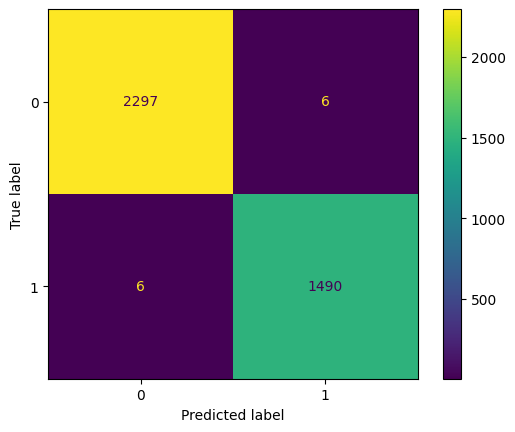

--- Testing the model on the test set ---
Classification Metrics for the test set is:

              precision    recall  f1-score   support

           0       0.74      0.89      0.81       578
           1       0.75      0.51      0.60       372

    accuracy                           0.74       950
   macro avg       0.74      0.70      0.71       950
weighted avg       0.74      0.74      0.73       950



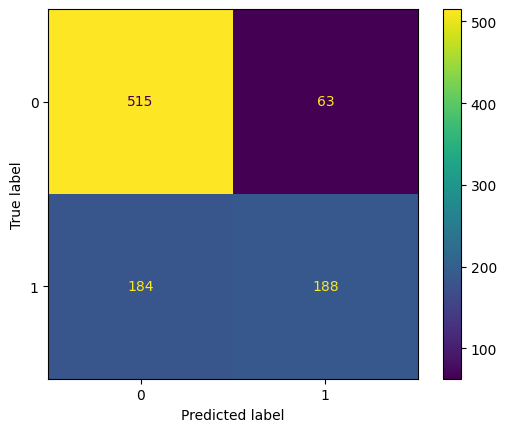

(3799, 5000)
(950, 5000)
(3799,)
(950,)


In [ ]:
fakenews.detect()

In [ ]:
fakenews.test_news(TESTFILE)

(6, 5000)
[[0.88 0.12]
 [0.83 0.17]
 [0.96 0.04]
 [0.16 0.84]
 [0.13 0.87]
 [0.09 0.91]]
[0 1]
